In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import data
df_cust = pd.read_csv('Customer.csv', delimiter=';')
df_prod = pd.read_csv('Product.csv', delimiter=';')
df_stor = pd.read_csv('Store.csv', delimiter=';')
df_tran = pd.read_csv('Transaction.csv', delimiter=';')

### data cleaning

In [5]:
print(df_cust.head())
print(df_cust.info())

   CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
None


 terdapat 3 null value pada kolom 'Marital Status'

In [6]:
print(df_prod.head())
print(df_prod.info())

  ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
None


In [7]:
print(df_stor.head())
print(df_stor.info())

   StoreID         StoreName GroupStore           Type   Latitude   Longitude
0        1     Prima Tendean      Prima   Modern Trade       -6,2  106,816666
1        2  Prima Kelapa Dua      Prima   Modern Trade  -6,914864  107,608238
2        3        Prima Kota      Prima   Modern Trade  -7,797068  110,370529
3        4       Gita Ginara       Gita  General Trade  -6,966667  110,416664
4        5           Bonafid       Gita  General Trade  -7,250445  112,768845
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
None


In [8]:
print(df_tran.head())
print(df_tran.info())

  TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6 

In [9]:
# mengubah kolom income, latitude dan longitude menjadi float dan mengganti ',' menjadi '.'
df_cust['Income'] = df_cust['Income'].replace('[,]','.',regex=True).astype('float')
df_stor['Latitude'] = df_stor['Latitude'].replace('[,]','.',regex=True).astype('float')
df_stor['Longitude'] = df_stor['Longitude'].replace('[,]','.',regex=True).astype('float')

In [10]:
# Mengisi kolom Marital Status yang kosong
marital = df_cust['Marital Status'].mode()[0]

# Mengisi nilai kosong dengan mode
df_cust['Marital Status'].fillna(marital, inplace=True)
df_cust['Marital Status'].isnull().sum()

0

In [11]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  447 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [12]:
# mengubah type data pada kolom 'Date' menjadi datetime
df_tran['Date'] = pd.to_datetime(df_tran['Date'])

### Menggabungkan semua data

In [13]:
df_merge = pd.merge(df_tran, df_cust, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_prod.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_stor, on=['StoreID'])

In [14]:
df_merge.head()

TransactionID  CustomerID       Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328 2022-01-01        P3   7500    4        30000   
1       TR89318         183 2022-07-17        P3   7500    1         7500   
2        TR9106         123 2022-09-26        P3   7500    4        30000   
3        TR4331         335 2022-08-01        P3   7500    3        22500   
4        TR6445         181 2022-10-01        P3   7500    4        30000   

   StoreID  Age  Gender Marital Status  Income Product Name       StoreName  \
0       12   36       0        Married   10.53     Crackers  Prestasi Utama   
1       12   27       1         Single    0.18     Crackers  Prestasi Utama   
2       12   34       0        Married    4.36     Crackers  Prestasi Utama   
3       12   29       1         Single    4.74     Crackers  Prestasi Utama   
4       12   33       1        Married    9.94     Crackers  Prestasi Utama   

  GroupStore           Type  Latitude   Longitude  
0   Prestasi  General Trade -2.990934  104.756554  
1   Prestasi  General Trade -2.990934  104.756554  
2   Prestasi  General Trade -2.990934  104.756554  
3   Prestasi  General Trade -2.990934  104.756554  
4   Prestasi  General Trade -2.990934  104.756554

## Model Machine Learning Regresi (Time series) dengan metode ARIMA

In [15]:
df_regresi = df_merge.groupby(['Date']).agg({'Qty' : 'sum'}).reset_index()

In [16]:
df_regresi

Date  Qty
0   2022-01-01   49
1   2022-01-02   50
2   2022-01-03   76
3   2022-01-04   98
4   2022-01-05   67
..         ...  ...
360 2022-12-27   70
361 2022-12-28   68
362 2022-12-29   42
363 2022-12-30   44
364 2022-12-31   37

[365 rows x 2 columns]

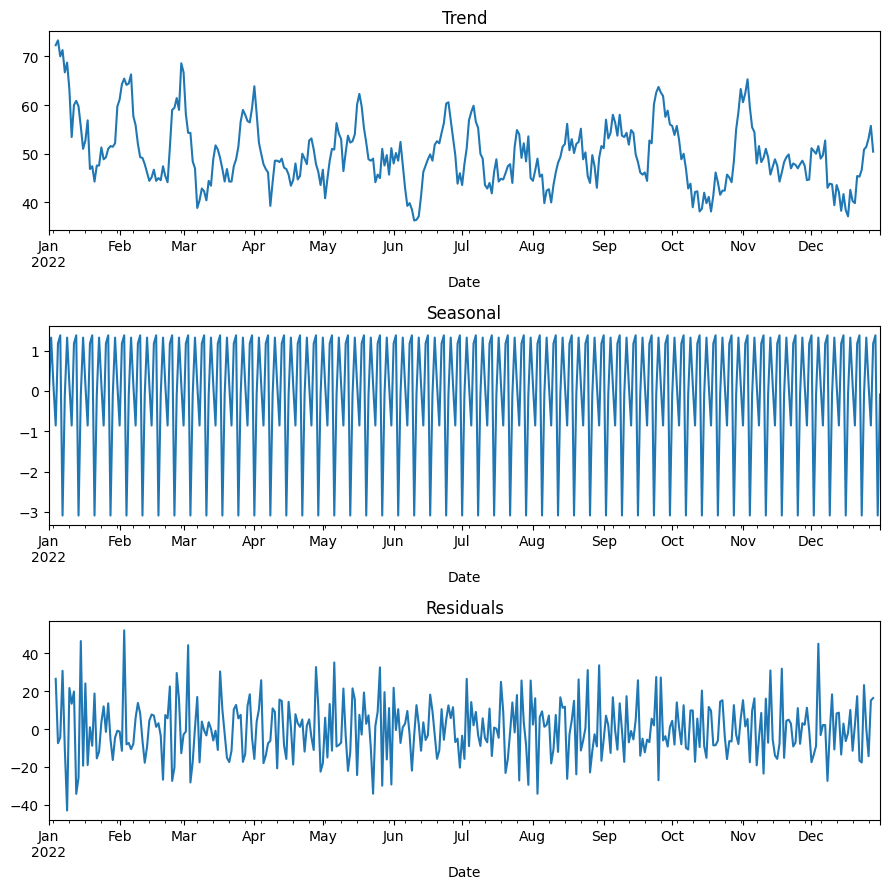

In [17]:
# membuat model decompose
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

# menampilkan hasil decompose
plt.figure(figsize=(9, 9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

In [18]:
# cek stationary data
cut_off = round(df_regresi.shape[0]*0.8)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [19]:
df_train

Date  Qty
0   2022-01-01   49
1   2022-01-02   50
2   2022-01-03   76
3   2022-01-04   98
4   2022-01-05   67
..         ...  ...
287 2022-10-15   33
288 2022-10-16   26
289 2022-10-17   53
290 2022-10-18   47
291 2022-10-19   34

[292 rows x 2 columns]

In [20]:
df_test

Date  Qty
0  2022-10-20   39
1  2022-10-21   35
2  2022-10-22   56
3  2022-10-23   59
4  2022-10-24   39
..        ...  ...
68 2022-12-27   70
69 2022-12-28   68
70 2022-12-29   42
71 2022-12-30   44
72 2022-12-31   37

[73 rows x 2 columns]

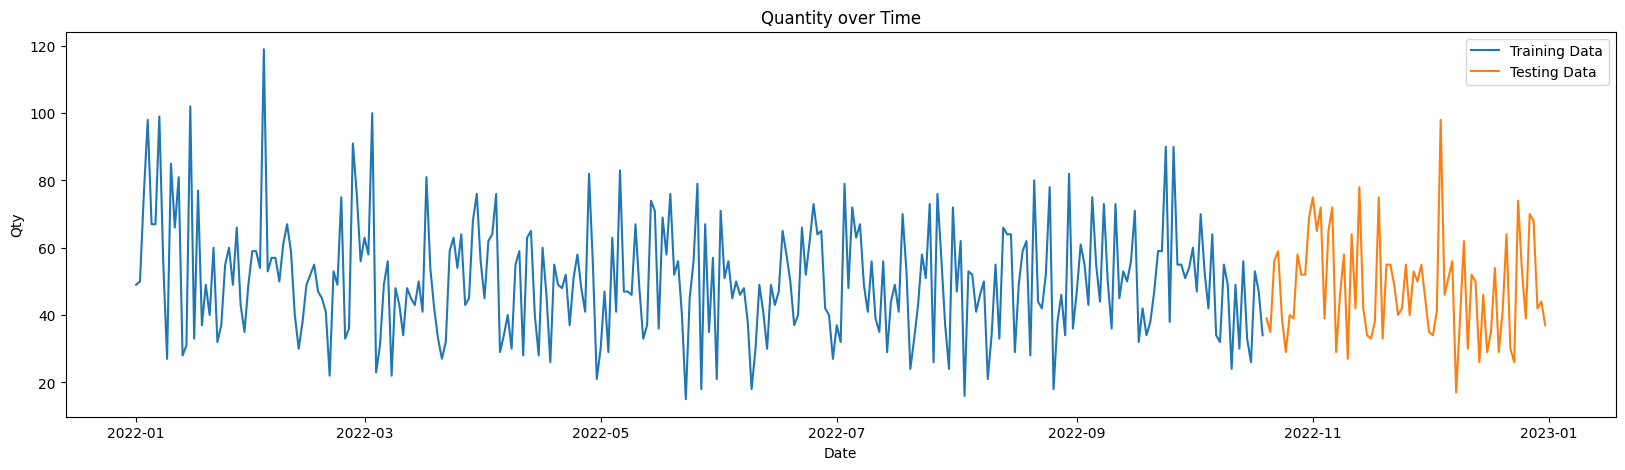

In [21]:
# menampilkan hasil plot
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'], label="Training Data");
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'], label="Testing Data");
plt.title("Quantity over Time")
plt.legend()
plt.show()

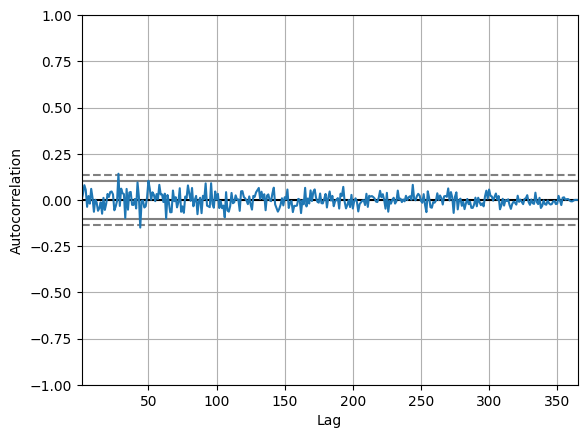

In [22]:
autocorrelation_plot(df_regresi['Qty']);

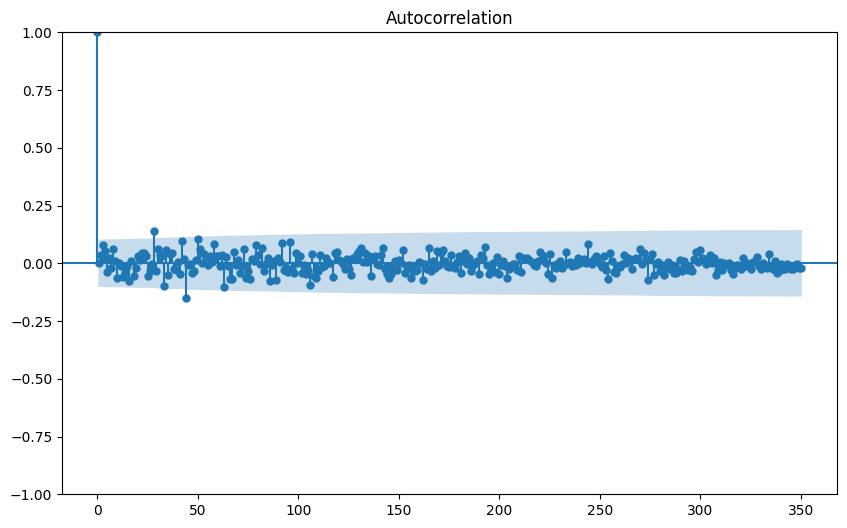

In [23]:
plt.figure(figsize=(10, 6))
plot_acf(df_regresi['Qty'], lags=350, ax=plt.gca())
plt.show()

In [24]:
def rmse(y_actual, y_pred):
    print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
    rmse(y_actual, y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

RMSE value 15.472386623448042
MAE value 12.357079825645519


<function matplotlib.pyplot.show(close=None, block=None)>

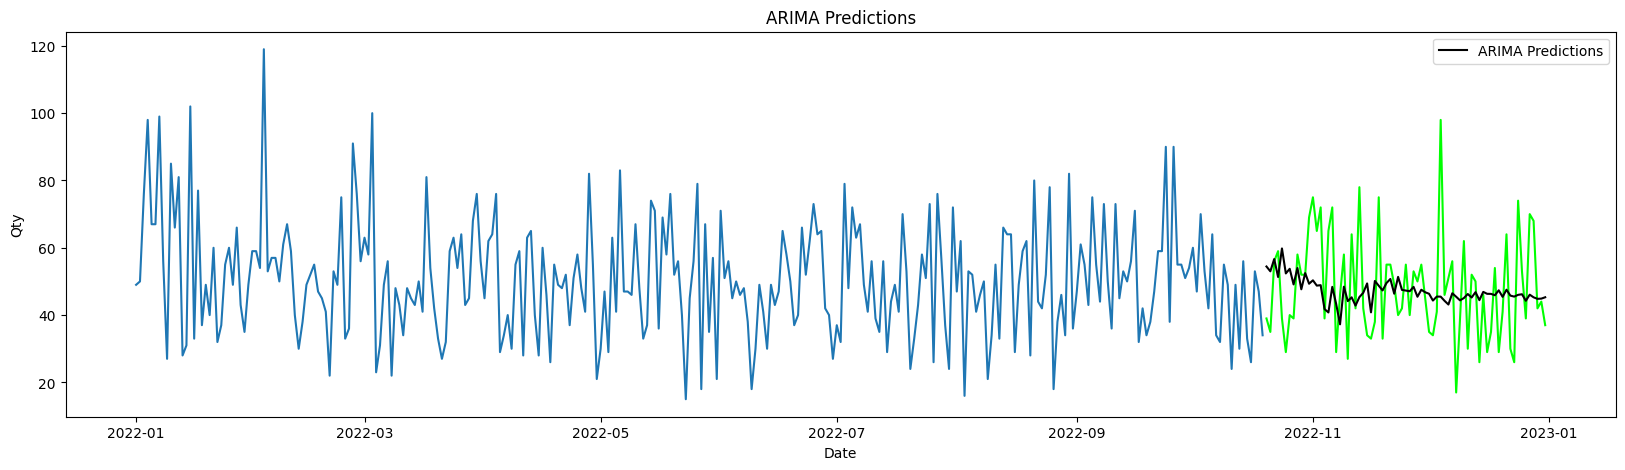

In [25]:
# ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMA_model = ARIMA(y, order = (40, 2, 1))
ARIMA_model = ARIMA_model.fit()

y_pred = ARIMA_model.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMA_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color = 'lime')
plt.plot(y_pred_out, color = 'black', label = 'ARIMA Predictions')
plt.xlabel("Date")
plt.ylabel("Qty")
plt.title("ARIMA Predictions")
plt.legend()
plt.show

### Clustering

In [26]:
df_merge.head()

TransactionID  CustomerID       Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328 2022-01-01        P3   7500    4        30000   
1       TR89318         183 2022-07-17        P3   7500    1         7500   
2        TR9106         123 2022-09-26        P3   7500    4        30000   
3        TR4331         335 2022-08-01        P3   7500    3        22500   
4        TR6445         181 2022-10-01        P3   7500    4        30000   

   StoreID  Age  Gender Marital Status  Income Product Name       StoreName  \
0       12   36       0        Married   10.53     Crackers  Prestasi Utama   
1       12   27       1         Single    0.18     Crackers  Prestasi Utama   
2       12   34       0        Married    4.36     Crackers  Prestasi Utama   
3       12   29       1         Single    4.74     Crackers  Prestasi Utama   
4       12   33       1        Married    9.94     Crackers  Prestasi Utama   

  GroupStore           Type  Latitude   Longitude  
0   Prestasi  General Trade -2.990934  104.756554  
1   Prestasi  General Trade -2.990934  104.756554  
2   Prestasi  General Trade -2.990934  104.756554  
3   Prestasi  General Trade -2.990934  104.756554  
4   Prestasi  General Trade -2.990934  104.756554

In [27]:
df_merge.corr()

CustomerID     Price       Qty  TotalAmount   StoreID       Age  \
CustomerID     1.000000 -0.016423 -0.009755    -0.024915  0.004129 -0.025952   
Price         -0.016423  1.000000 -0.353640     0.440632 -0.032863  0.014693   
Qty           -0.009755 -0.353640  1.000000     0.621129  0.014365 -0.027768   
TotalAmount   -0.024915  0.440632  0.621129     1.000000 -0.010722 -0.016900   
StoreID        0.004129 -0.032863  0.014365    -0.010722  1.000000 -0.003872   
Age           -0.025952  0.014693 -0.027768    -0.016900 -0.003872  1.000000   
Gender        -0.009947  0.010705 -0.010542    -0.008774 -0.000189 -0.033183   
Income         0.005783  0.001196 -0.028425    -0.025350  0.001613  0.486692   
Latitude       0.002278 -0.029008 -0.004170    -0.029938  0.471852  0.009266   
Longitude     -0.003122  0.018652  0.004807     0.025437 -0.094943  0.015951   

               Gender    Income  Latitude  Longitude  
CustomerID  -0.009947  0.005783  0.002278  -0.003122  
Price        0.010705  0.001196 -0.029008   0.018652  
Qty         -0.010542 -0.028425 -0.004170   0.004807  
TotalAmount -0.008774 -0.025350 -0.029938   0.025437  
StoreID     -0.000189  0.001613  0.471852  -0.094943  
Age         -0.033183  0.486692  0.009266   0.015951  
Gender       1.000000 -0.071443 -0.006051  -0.001183  
Income      -0.071443  1.000000  0.015518   0.004385  
Latitude    -0.006051  0.015518  1.000000  -0.395995  
Longitude   -0.001183  0.004385 -0.395995   1.000000

In [28]:
# memilih kolom untuk membuat cluster
df_cluster = df_merge.groupby(['CustomerID']).agg({'TransactionID' : 'count', 'Qty' : 'sum'}).reset_index()

In [29]:
df_cluster

CustomerID  TransactionID  Qty
0             1             17   60
1             2             13   57
2             3             15   56
3             4             10   46
4             5              7   27
..          ...            ...  ...
442         443             16   59
443         444             18   62
444         445             18   68
445         446             11   42
446         447             13   42

[447 rows x 3 columns]

In [30]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [31]:
data_cluster_normalize

array([[0.27260257, 0.96212673],
       [0.22236034, 0.97496455],
       [0.25873609, 0.96594805],
       [0.21242964, 0.97717636],
       [0.25096216, 0.9679969 ],
       [0.2216211 , 0.97513286],
       [0.28580512, 0.95828776],
       [0.28547659, 0.95838568],
       [0.2216211 , 0.97513286],
       [0.26962993, 0.96296402],
       [0.24253563, 0.9701425 ],
       [0.25371269, 0.96727962],
       [0.26910454, 0.96311097],
       [0.32432432, 0.94594595],
       [0.26311741, 0.96476382],
       [0.25163385, 0.96782251],
       [0.25912857, 0.96584284],
       [0.30320366, 0.95292578],
       [0.23162053, 0.97280621],
       [0.27232247, 0.96220605],
       [0.27472113, 0.96152395],
       [0.26879897, 0.9631963 ],
       [0.26311741, 0.96476382],
       [0.29568373, 0.95528589],
       [0.28734789, 0.95782629],
       [0.30782029, 0.95144452],
       [0.29827499, 0.95447998],
       [0.28216632, 0.9593655 ],
       [0.23162053, 0.97280621],
       [0.24253563, 0.9701425 ],
       [0.

In [33]:
K = range(2, 8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state= 0, n_init='auto').fit(data_cluster_normalize)
    fits.append(model)
    score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

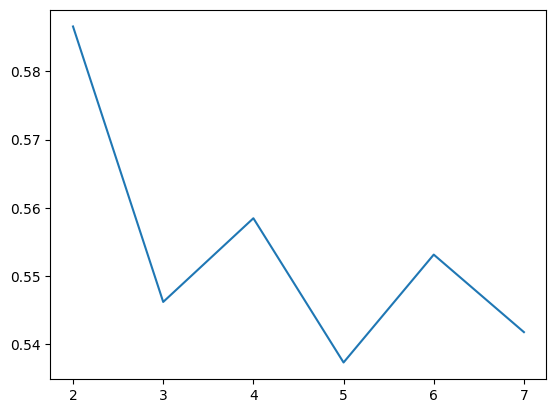

In [34]:
# memilih cluster
sns.lineplot(x = K, y = score);

In [37]:
df_cluster['cluster_label'] = fits[1].labels_

In [38]:
df_cluster.groupby(['cluster_label']).agg({'CustomerID' : 'count', 'TransactionID' : 'mean', 'Qty' : 'mean'})

CustomerID  TransactionID        Qty
cluster_label                                      
0                     211      11.857820  42.644550
1                     102      11.176471  32.637255
2                     134      10.283582  44.544776

Cluster 0: memiliki jumlah customer terbanyak dengan quantity berada di tengah antara cluster yang lain

Cluster 1: cluster dengan jumlah quantity dan customer yang paling sedikit

cluster 2: memiliki jumlah quantity terbanyak namun jumlah transaction paling sedikit bisa didapatkan customer membeli barang lebih dari satu setiap belanja

# Business Recomendation
Cluster 0: identifikasi produk yang paling diminati customer dalam cluster ini lalu menawarkan diskon untuk produk yang relevan.

Cluster 1: memperluas jangkauan atau meningkatkan pemasaran pada produk untuk menarik lebih banyak customer, memahami mengapa jumlah pembelian yang lebih sedikit dibanding cluster yang lain.

Cluster 2: menawarkan bundle produk yang menarik customer, menarwarkan 'member card' kepada customer dalam cluster ini.  